Team: 21

- Praanshu Patel (23110249)
- Rishank Soni (23110277)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os

# Importing files
if os.path.exists("train.tsv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv

if os.path.exists("test.tsv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv

File exists
File exists


In [5]:
# Loading the datasets
import pandas as pd
import numpy as np

def extractfiles(file):
    df = pd.read_csv(file, sep='\t', header=None)
    df.columns = ['text', 'label']

    # Extracting text
    df['text'] = df['text'].astype(str).apply(lambda x: x.replace('\t', ''))

    # Extracting labels
    df['label'] = df['label'].astype(str).apply(lambda x: x.replace('\n', ''))
    df['label'] = df['label'].astype(int)

    # Printing counts to ensure no imbalance of classes
    print("Counts of each label:")
    print(df['label'].value_counts())

    df.head(10)

    return df

traindf = extractfiles("train.tsv")
test = extractfiles("test.tsv")

Counts of each label:
label
1    3610
0    3310
Name: count, dtype: int64
Counts of each label:
label
0    912
1    909
Name: count, dtype: int64


In [6]:
# Split the dataset 1 into train and validation
from sklearn.model_selection import train_test_split

train, val = train_test_split(traindf, test_size=0.2, random_state=11)
print(f"Train shape: {train.shape}, Validation shape: {val.shape}")

train.head()

Train shape: (5536, 2), Validation shape: (1384, 2)


,text,label
1934,"for those in search of something different , w...",1
3425,"yes , mibii is rote work and predictable , but...",1
6025,this is an insultingly inept and artificial ex...,0
6478,"plunges you into a reality that is , more ofte...",1
1084,the problem with the mayhem in formula 51 is n...,0


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Model architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(10000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        return x

In [8]:
# Instantiate model
model = NeuralNetwork()

# Print summary
from torchsummary import summary
summary(model, (1, 10000)) # 1 is the batch size and 10000 is the input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       5,120,512
           Dropout-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
           Dropout-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
           Dropout-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
           Dropout-8                [-1, 1, 64]               0
Total params: 5,292,992
Trainable params: 5,292,992
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.01
Params size (MB): 20.19
Estimated Total Size (MB): 20.24
----------------------------------------------------------------


In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5293122


In [10]:
# Training the model on 10 epochs and creating the best performing model

import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train['text']).toarray()
X_val = vectorizer.transform(val['text']).toarray()
X_test = vectorizer.transform(test['text']).toarray()
# Convert to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(train['label'].values, dtype=torch.long)
val_features = torch.tensor(X_val, dtype=torch.float32)
val_labels = torch.tensor(val['label'].values, dtype=torch.long)
test_features = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(test['label'].values, dtype=torch.long)

print(f"Train features shape: {train_features.shape}, Validation features shape: {val_features.shape}, Test features shape: {test_features.shape}")


Train features shape: torch.Size([5536, 10000]), Validation features shape: torch.Size([1384, 10000]), Test features shape: torch.Size([1821, 10000])


In [12]:
# Train the model for 10 epochs, save the best model as 'checkpoint.pt', and plot validation accuracy & loss

num_epochs = 10
batch_size = 64
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

best_val_acc = 0.0
train_losses, val_losses = [], []
val_accuracies = []



Epoch 1/10 | Train Loss: 2.4897 | Val Loss: 1.3552 | Val Acc: 0.5340
Epoch 2/10 | Train Loss: 2.1132 | Val Loss: 1.3943 | Val Acc: 0.5340
Epoch 3/10 | Train Loss: 1.9932 | Val Loss: 1.1234 | Val Acc: 0.7666
Epoch 4/10 | Train Loss: 1.5956 | Val Loss: 0.8980 | Val Acc: 0.7637
Epoch 5/10 | Train Loss: 1.3659 | Val Loss: 1.1408 | Val Acc: 0.7673
Epoch 6/10 | Train Loss: 1.3276 | Val Loss: 1.2858 | Val Acc: 0.7616
Epoch 7/10 | Train Loss: 1.2696 | Val Loss: 1.4373 | Val Acc: 0.7449
Epoch 8/10 | Train Loss: 1.2330 | Val Loss: 1.5040 | Val Acc: 0.7514
Epoch 9/10 | Train Loss: 1.2635 | Val Loss: 1.6380 | Val Acc: 0.7464
Epoch 10/10 | Train Loss: 1.2569 | Val Loss: 1.6962 | Val Acc: 0.7493


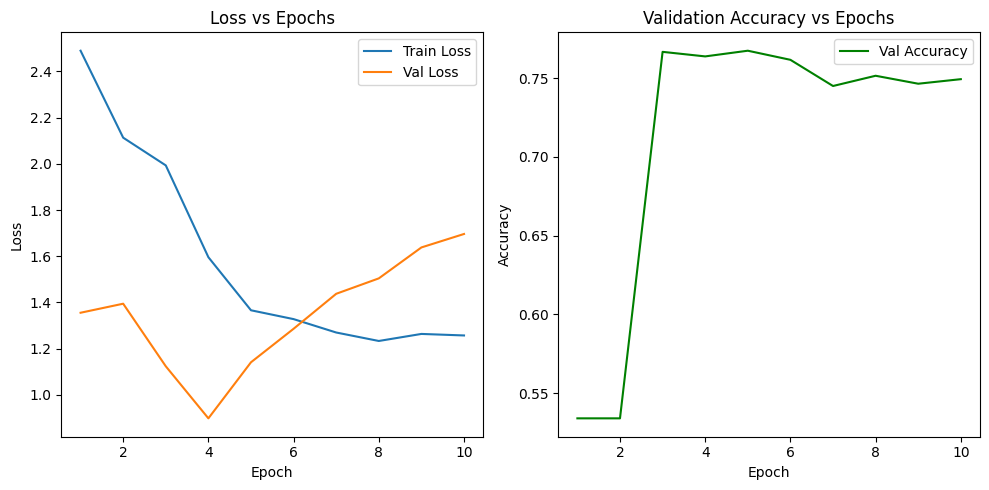

In [13]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoint.pt")

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Plotting
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Load the best model
model.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [15]:
# for mac os
torch.backends.quantized.engine = 'qnnpack'


In [16]:
# Calculating the following metrics:
# 1. Accuracy on test set
# 2. Model size in MB
# 3. Inference time on test set
import time
import io
# Function to calculate all metrics
def calculate_metrics(model, test_features, test_labels, model_data_type):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    # Inference time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
    inference_time = time.time() - start_time

    # Accuracy
    correct = (predicted == test_labels).sum().item()
    accuracy = correct / len(test_labels)

    # Compute model size in MB by serializing the model state
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    model_size = buffer.getbuffer().nbytes / (1024 * 1024)

    return accuracy, model_size, inference_time

In [17]:
# Calculating metrics for current model (FLOAT32)
accuracy_float32, model_size_float32, inference_time_float32 = calculate_metrics(model, test_features, test_labels, "FLOAT32")
dict_metrics_float32 = {
    "Model Name": "Original",
    "Accuracy (Out of 100)": accuracy_float32,
    "Storage (in MB)": model_size_float32,
    "Inference Time (in ms)": inference_time_float32 * 1000,  # Convert to milliseconds
}
print(dict_metrics_float32)

{'Model Name': 'Original', 'Accuracy (Out of 100)': 0.7896760021965953, 'Storage (in MB)': 20.19463348388672, 'Inference Time (in ms)': 83.41717720031738}


In [18]:
# INT 8 Dynamic Quantization
import io
import torch.quantization as quantization
# Set the model to evaluation mode and apply dynamic quantization
# Load the model and set it to evaluation mode
model = NeuralNetwork()
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
quantized_model = quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Reconvert test features to their original data type
X_test = vectorizer.transform(test['text']).toarray()
# Convert to PyTorch tensors
test_features = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(test['label'].values, dtype=torch.long)

# Calculate metrics for INT 8 quantized model
accuracy_int8, model_size_int8, inference_time_int8 = calculate_metrics(quantized_model, test_features, test_labels, "INT8")
dict_metrics_int8 = {
    "Model Name": "Dynamic",
    "Accuracy (Out of 100)": accuracy_int8,
    "Storage (in MB)": model_size_int8,
    "Inference Time (in ms)": inference_time_int8 * 1000,  # Convert to milliseconds
}

print(dict_metrics_int8)


{'Model Name': 'Dynamic', 'Accuracy (Out of 100)': 0.7902251510159253, 'Storage (in MB)': 5.056848526000977, 'Inference Time (in ms)': 103.25813293457031}


[W419 19:12:37.754874000 qlinear_dynamic.cpp:251] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


In [19]:
# FLOAT 16 Quantization (using .half())
# Clear the model and load the best model again
model = NeuralNetwork()
model.load_state_dict(torch.load("checkpoint.pt"))
model.half()  # Convert model to half precision (FLOAT16)
model.eval()

# Reconvert test features to their original data type
X_test = vectorizer.transform(test['text']).toarray()
# Convert to PyTorch tensors
test_features = torch.tensor(X_test, dtype=torch.float16)
test_labels = torch.tensor(test['label'].values, dtype=torch.long)

# Calculate metrics for FLOAT 16 quantized model
accuracy_float16, model_size_float16, inference_time_float16 = calculate_metrics(model, test_features, test_labels, "FLOAT16")
dict_metrics_float16 = {
    "Model Name": "Half",
    "Accuracy (Out of 100)": accuracy_float16,
    "Storage (in MB)": model_size_float16,
    "Inference Time (in ms)": inference_time_float16 * 1000,  # Convert to milliseconds
}
print(dict_metrics_float16)

{'Model Name': 'Half', 'Accuracy (Out of 100)': 0.7896760021965953, 'Storage (in MB)': 10.098808288574219, 'Inference Time (in ms)': 153.06878089904785}


In [20]:
# Make a dataframe of all the metrics
import pandas as pd
import numpy as np

# Create a DataFrame from the dictionaries
metrics_list = [dict_metrics_float32, dict_metrics_int8, dict_metrics_float16]
metrics_df = pd.DataFrame(metrics_list)
# Convert the accuracy to percentage
metrics_df['Accuracy (Out of 100)'] = metrics_df['Accuracy (Out of 100)'] * 100
# Convert the storage to MB
metrics_df['Storage (in MB)'] = metrics_df['Storage (in MB)'].apply(lambda x: round(x, 2))
# Convert the inference time to milliseconds
metrics_df['Inference Time (in ms)'] = metrics_df['Inference Time (in ms)'].apply(lambda x: round(x, 2))
# Display the DataFrame
display(metrics_df)


,Model Name,Accuracy (Out of 100),Storage (in MB),Inference Time (in ms)
0,Original,78.967600,20.19,83.42
1,Dynamic,79.022515,5.06,103.26
2,Half,78.967600,10.10,153.07
